# Imports

In [1]:
import pickle
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import seaborn as sns

from tools import get_mids
from fluxes import power_law



Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
matplotlib = sns.mpl
plt = matplotlib.pyplot

def reset_mpl_settings():
    plt.style.use("../style.mplstyle")
    colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return colorlist
colorlist = reset_mpl_settings()

# Load data

In [5]:
# set up binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

In [19]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# MCEQ - High energies
with open("../resources/MCEq_flux_HE.pckl", "rb") as f:
    (e_grid_HE, zen_HE), flux_def_HE = pickle.load(f)

# moved to script 'atmospheric_background.py'

# Show the background spectrum

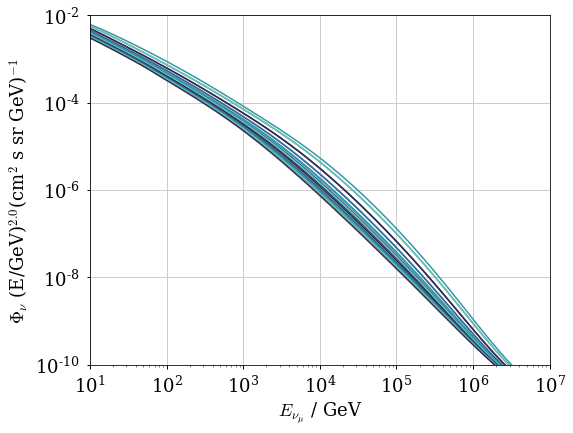

In [7]:
spec = 2.
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([('numu_', r'\nu_\mu')]):

        p0 = ax.loglog(
            e_grid,
            e_grid**(spec)*flux_def[pref + 'total'][:,ti],
            ls='solid',
            lw=1.5,
        )
    
ax.set_xlim(10,1e7)
ax.set_ylim(1e-10,1e-2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()

## with HE extension

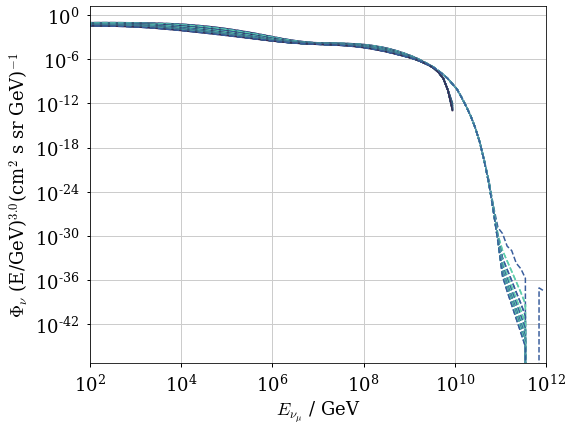

In [22]:

spec = 3.
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):
        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * flux_def[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
        p0 = ax.loglog(
            e_grid_HE,
            e_grid_HE ** (spec) * flux_def_HE[pref + "total"][:, ti],
            ls="dashed",
            lw=1.5,
        )

ax.set_xlim(1E2, 1e12)
#ax.set_ylim(0.1, 1e2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


## with astro flux as comparison

In [23]:
from settings import GAMMA_ASTRO, PHI_ASTRO, LIVETIME, E_NORM

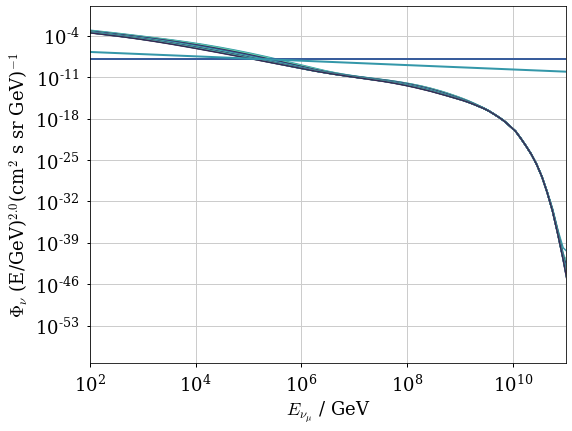

In [30]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):
        p0 = ax.loglog(
            e_grid_HE,
            e_grid_HE ** (spec) * flux_def_HE[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
ax.loglog(
    e_grid_HE, power_law(e_grid_HE, 1e5, 2, 1e-18) * e_grid_HE ** (spec)
)  # generic spectrum
ax.loglog(
    e_grid_HE, power_law(e_grid_HE, 1e5, GAMMA_ASTRO, PHI_ASTRO) * e_grid_HE ** (spec)
)  # best-fit numu
ax.set_xlim(1E2, 1e11)
#ax.set_ylim(1e-30, 1e-2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


## check event numbers with effective areas

In [39]:
with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

In [41]:
# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * 2*np.pi

In [42]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det]) * LIVETIME
    astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 673591.4004657972
astro events: 2337.493526416219
Plenum-1
conv events: 2711650.574116629
astro events: 9348.156416904032


## visualization

In [14]:
closest_MCEq_energy_idx = lambda e: np.argmin(np.abs(e-e_grid))
closest_MCEq_ang_idx = lambda t: np.argmin(np.abs(t-zen))

# get the mceq flux values within the respective energy bins
ind_mceq_e = np.array([closest_MCEq_energy_idx(ei) for ei in emids])
ind_mceq_t = np.array([closest_MCEq_ang_idx(ti) for ti in np.rad2deg(np.arcsin(sindec_mids)) + 90])
scaler = 3.7

tck_numu = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)

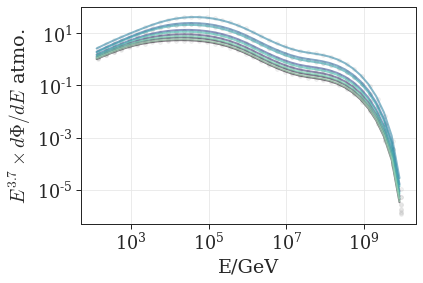

In [17]:
skipper = 5
sns.set_palette("mako", len(sindec_mids)//skipper)


fig, ax = plt.subplots()
for ti, sdm in enumerate(sindec_mids[::skipper]):
    spl_vals = np.exp(tck_numu((emids, np.full_like(emids, sdm))))
    ax.plot(emids, spl_vals * emids**scaler, alpha=0.6)
    ax.scatter(
        e_grid[ind_mceq_e],
        flux_def['numu_conv'][ind_mceq_e, ind_mceq_t[ti*skipper]] * e_grid[ind_mceq_e]**scaler,
        marker='o',
        s=15,
        color="gray",
        alpha=0.1
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E/GeV')
    ax.set_ylabel(r"$E^{3.7} \times d\Phi / dE$ atmo.")


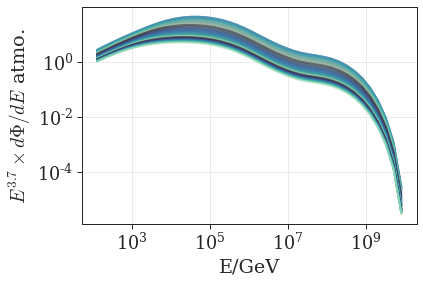

In [18]:
sns.set_palette("mako", len(sindec_mids)//5)

fig, ax = plt.subplots()
for ti, sdm in enumerate(sindec_mids):#[:100:3]):
    spl_vals = np.exp(tck_numu((emids, np.full_like(emids, sdm))))
    ax.plot(emids, spl_vals * emids**scaler, alpha=0.6)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E/GeV')
    ax.set_ylabel(r"$E^{3.7} \times d\Phi / dE$ atmo.")
